In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from models.resnet34_yolo import resnet34_yolo as used_model
import config
from torch.utils.data import DataLoader
import pandas as pd

from utils import (
    mean_average_precision,
    get_bboxes,
)

In [2]:
folder = "../runs/ResNet/dropout-0.1/2023-02-12_14-14-14"
path_to_model = folder + "/model.pt"
dropout = 0.1

cfg = config.Config().replace(DROPOUT=dropout, BATCH_SIZE=16)
model = used_model(split_size=cfg.SPLIT_SIZE, num_boxes=cfg.NUM_BOXES, num_classes=cfg.NUM_CLASSES, dropout_percentage=cfg.DROPOUT).to(cfg.DEVICE)
model.load_state_dict(torch.load(path_to_model, map_location=torch.device(cfg.DEVICE)))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
IMAGE_SIZE = 448

data_preprocess = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

In [4]:
DATASET_PATH = '../downloads/TACO/data'
anns_file_path = DATASET_PATH + '/' + 'annotations.json'

In [5]:
from taco_dataset import CoCoDatasetForYOLO

test_dataset = CoCoDatasetForYOLO(
    root=DATASET_PATH,
    annFile=anns_file_path,
    transform=data_preprocess,
    C=1
)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [6]:
test_df = pd.read_csv(cfg.test_indices_path)
test_indices = torch.tensor(test_df['test_indices'].values)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=cfg.BATCH_SIZE,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=cfg.PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

In [7]:
with torch.no_grad():
    pred_boxes, target_boxes = get_bboxes(
        test_loader, model, iou_threshold=cfg.iou_threshold, threshold=cfg.threshold, device=cfg.DEVICE,
        S=cfg.SPLIT_SIZE, B=cfg.NUM_BOXES, C=cfg.NUM_CLASSES
    )

In [8]:
# from collections import Counter
# import torch
# from utils import intersection_over_union
# import matplotlib.pyplot as plt

# def mean_average_precision_a(
#     pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20, print_output=False
# ):
#     """
#     Calculates mean average precision 

#     Parameters:
#         pred_boxes (list): list of lists containing all bboxes with each bboxes
#         specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
#         true_boxes (list): Similar as pred_boxes except all the correct ones 
#         iou_threshold (float): threshold where predicted bboxes is correct
#         box_format (str): "midpoint" or "corners" used to specify bboxes
#         num_classes (int): number of classes

#     Returns:
#         float: mAP value across all classes given a specific IoU threshold 
#     """

#     # list storing all AP for respective classes
#     average_precisions = []

#     # used for numerical stability later on
#     epsilon = 1e-6

#     for c in range(num_classes):
#         detections = []
#         ground_truths = []

#         # Go through all predictions and targets,
#         # and only add the ones that belong to the
#         # current class c
#         for detection in pred_boxes:
#             if detection[1] == c:
#                 detections.append(detection)

#         for true_box in true_boxes:
#             if true_box[1] == c:
#                 ground_truths.append(true_box)

#         # find the amount of bboxes for each training example
#         # Counter here finds how many ground truth bboxes we get
#         # for each training example, so let's say img 0 has 3,
#         # img 1 has 5 then we will obtain a dictionary with:
#         # amount_bboxes = {0:3, 1:5}
#         amount_bboxes = Counter([gt[0] for gt in ground_truths])

#         # We then go through each key, val in this dictionary
#         # and convert to the following (w.r.t same example):
#         # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
#         for key, val in amount_bboxes.items():
#             amount_bboxes[key] = torch.zeros(val)

#         # sort by box probabilities which is index 2
#         detections.sort(key=lambda x: x[2], reverse=True)
#         TP = torch.zeros((len(detections)))
#         FP = torch.zeros((len(detections)))
#         total_true_bboxes = len(ground_truths)
        
#         # If none exists for this class then we can safely skip
#         if total_true_bboxes == 0:
#             continue

#         for detection_idx, detection in enumerate(detections):
#             # Only take out the ground_truths that have the same
#             # training idx as detection
#             ground_truth_img = [
#                 bbox for bbox in ground_truths if bbox[0] == detection[0]
#             ]

#             num_gts = len(ground_truth_img)
#             best_iou = 0

#             for idx, gt in enumerate(ground_truth_img):
#                 iou = intersection_over_union(
#                     torch.tensor(detection[3:]),
#                     torch.tensor(gt[3:]),
#                     box_format=box_format,
#                 )

#                 if iou > best_iou:
#                     best_iou = iou
#                     best_gt_idx = idx

#             if best_iou > iou_threshold:
#                 # only detect ground truth detection once
#                 if amount_bboxes[detection[0]][best_gt_idx] == 0:
#                     # true positive and add this bounding box to seen
#                     TP[detection_idx] = 1
#                     amount_bboxes[detection[0]][best_gt_idx] = 1
#                 else:
#                     FP[detection_idx] = 1

#             # if IOU is lower then the detection is a false positive
#             else:
#                 FP[detection_idx] = 1

#         TP_cumsum = torch.cumsum(TP, dim=0)
#         FP_cumsum = torch.cumsum(FP, dim=0)
#         recalls = TP_cumsum / (total_true_bboxes + epsilon)
#         precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
#         precisions = torch.cat((torch.tensor([1]), precisions))
#         recalls = torch.cat((torch.tensor([0]), recalls))
#         # torch.trapz for numerical integration
#         average_precisions.append(torch.trapz(precisions, recalls))

#         if print_output:
#             print(f"Class: {c}")

#             print(f"TP: {TP_cumsum[-1]}")
#             print(f"FP: {FP_cumsum[-1]}")
#             print(f"\nTrue boxes: {total_true_bboxes}")
#             print(f"\nRecall: {recalls[-1]}")
#             print(f"Precision: {precisions[-1]}")

#             plt.plot(recalls.tolist(), precisions.tolist())
#             plt.fill_between(recalls.tolist(), precisions.tolist(), alpha=0.3)
#             plt.grid()
#             axes = plt.gca()
#             axes.set_xlim([0,1])
#             plt.show()

#     return sum(average_precisions) / len(average_precisions)

Class: 0
TP: 141.0
FP: 344.0

True boxes: 715

Recall: 0.19720280170440674
Precision: 0.2907216548919678


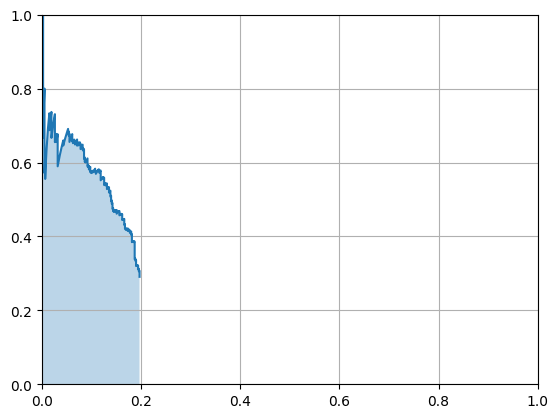

tensor(0.1125)


In [9]:
mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=cfg.iou_threshold, box_format=cfg.box_format, num_classes=cfg.NUM_CLASSES, print_output=True
)

print(mean_avg_prec)